In [1]:
from models import get_model
import torch

import torch.nn as nn

C:\Users\Achyut Burlakoti\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
model = get_model('resnet')

model.to(torch.device('cuda'))

C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetFeatureModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [3]:
path = './models/res-net.pt'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
from dataset import ImageDataset

In [5]:
BATCH_SIZE = 16

In [6]:
test_dataset = ImageDataset(status="test", h=224, w=224)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
last_conv_output = None

def hook(module, input, out):
    global last_conv_output
    last_conv_output = out

In [8]:
model.net[7][2].conv3.register_forward_hook(hook)

In [9]:
import numpy as np
import scipy.ndimage

import matplotlib.pyplot as plt

In [10]:
model.eval()

ResNetFeatureModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [11]:
# get image from test dataset

input = test_dataset.__getitem__(1000)[0]
data = input.permute(1, 2 ,0)
input = input.unsqueeze(0)

pred_vec = model(input.to(torch.device('cuda')))

last_conv_output = last_conv_output.squeeze(0)
last_conv_output = last_conv_output.permute(1, 2, 0)

pred = np.argmax(pred_vec.cpu().detach().numpy())

In [12]:
print("Predicted Label : ", pred, " Actual Label : ", test_dataset.__getitem__(1000)[1])

Predicted Label :  1  Actual Label :  1


In [13]:
last_conv_output.shape

torch.Size([7, 7, 2048])

In [16]:
# upscaling the last convolutional layer output

h = int(224 / last_conv_output.shape[0])
w = int(224 / last_conv_output.shape[1])

upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output.cpu().detach().numpy(), (h, w, 1), order=1)

last_layer_weights = model.linear[-1].weight
last_layer_weights = last_layer_weights.permute(1, 0)

last_layer_weights_for_pred = last_layer_weights[:, pred]

In [18]:
heat_map = np.dot(upsampled_last_conv_output.reshape((64*64, 2048)), last_layer_weights_for_pred.cpu().detach().numpy()).reshape(64, 64)

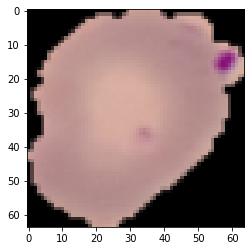

In [19]:
fig, ax = plt.subplots()
ax.imshow(data)
#ax.imshow(heat_map, cmap='jet', alpha=0.5)

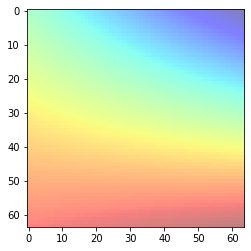

In [20]:
fig, ax = plt.subplots()
#ax.imshow(data)
ax.imshow(heat_map, cmap='jet', alpha=0.5)

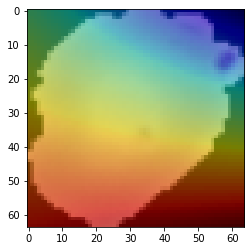

In [21]:
fig, ax = plt.subplots()
ax.imshow(data)
ax.imshow(heat_map, cmap='jet', alpha=0.5)